# Алгоритм пытается автоматически определить два типа рыночного поведения:
* Трендовый режим - когда цена движется направленно (вверх или вниз)
* Mean Reversion режим - когда цена колеблется вокруг среднего значения


## Шаг 1: Расчет технических индикаторов
Сначала вычисляются классические технические показатели:
* Скользящие средние (SMA, EMA)
* RSI, MACD
* Полосы Боллинджера
* Волатильность
* ATR (средний истинный диапазон)

## Шаг 2: Создание признаков для кластеризации
* Из технических индикаторов извлекаются 6 ключевых признаков:
#### 1. Волатильность (Volatility):
* Volatility = std(returns) × √96, где returns = (close_t - close_t-1) / close_t-1
#### 2. Сила тренда (Trend Strength):
* Trend_Strength = |price_change_96_periods|, где price_change = (close_t - close_t-96) / close_t-96

#### 3. Отклонение от скользящей средней:
* SMA_Deviation = |(close - SMA_20) / SMA_20|
#### 4. Отклонение RSI от нейтрального уровня:
* RSI_Deviation = |RSI - 50| / 50

#### 5. Экстремальная позиция в полосах Боллинджера:
* BB_Position_Extreme = {
* BB_Position - 0.8, если BB_Position > 0.8
* 0.2 - BB_Position, если BB_Position < 0.2
* 0, в остальных случаях }
* где BB_Position = (close - BB_lower) / (BB_upper - BB_lower)

#### 6. Нормализованная сила MACD:
* MACD_Strength = |MACD_Histogram| / close

## Шаг 3: Стандартизация признаков
* Все признаки приводятся к одному масштабу:
* Feature_scaled = (Feature - mean(Feature)) / std(Feature)

## Шаг 4: K-means кластеризация
* Алгоритм K-means группирует все временные точки в 2 кластера, минимизируя внутрикластерное расстояние:
* Цель: минимизировать Σ ||x_i - c_j||², где x_i - точка данных, c_j - центр кластера j

## Шаг 5: Интерпретация кластеров
После кластеризации определяется, какой кластер соответствует какому режиму:

* if mean(Volatility_cluster_0) > mean(Volatility_cluster_1): Cluster_0 = "Trending", Cluster_1 = "Mean Reversion"
* else: Cluster_0 = "Mean Reversion", Cluster_1 = "Trending"

#### Логика интерпретации:
* Трендовый режим: высокая волатильность + высокая сила тренда + большие отклонения от средних
* Mean Reversion режим: низкая волатильность + слабый тренд + цена близко к средним значениям

## Шаг 6: Сглаживание сигналов
Чтобы избежать частых переключений между режимами, применяется фильтр минимальной длительности (8 периодов = 2 часа)

## Результат анализа:
84.9% времени рынок находился в режиме Mean Reversion
15.1% времени - в трендовом режиме
Всего сгенерировано 88 торговых сигналов (51 long, 37 short)

Загрузка данных с Binance...
Загружено 2977 свечей
Расчет технических индикаторов...
Создание признаков для кластеризации...
Применение K-means кластеризации...
Сглаживание сигналов режима...
Генерация торговых сигналов...
АНАЛИЗ СТАДИЙ РЫНКА BTC/USDT
Период анализа: 2025-01-02 00:00 - 2025-02-01 00:00
Общее количество периодов: 2881
Трендовых периодов: 434 (15.1%)
Mean Reversion периодов: 2447 (84.9%)

СТАТИСТИКА СИГНАЛОВ MEAN REVERSION:
Всего сигналов: 88
Long сигналов: 51
Short сигналов: 37

РЕКОМЕНДАЦИИ:
✅ Высокий процент Mean Reversion периодов - стратегия может быть эффективной
📊 Среднее количество сигналов в день: 2.9
Создание графиков...


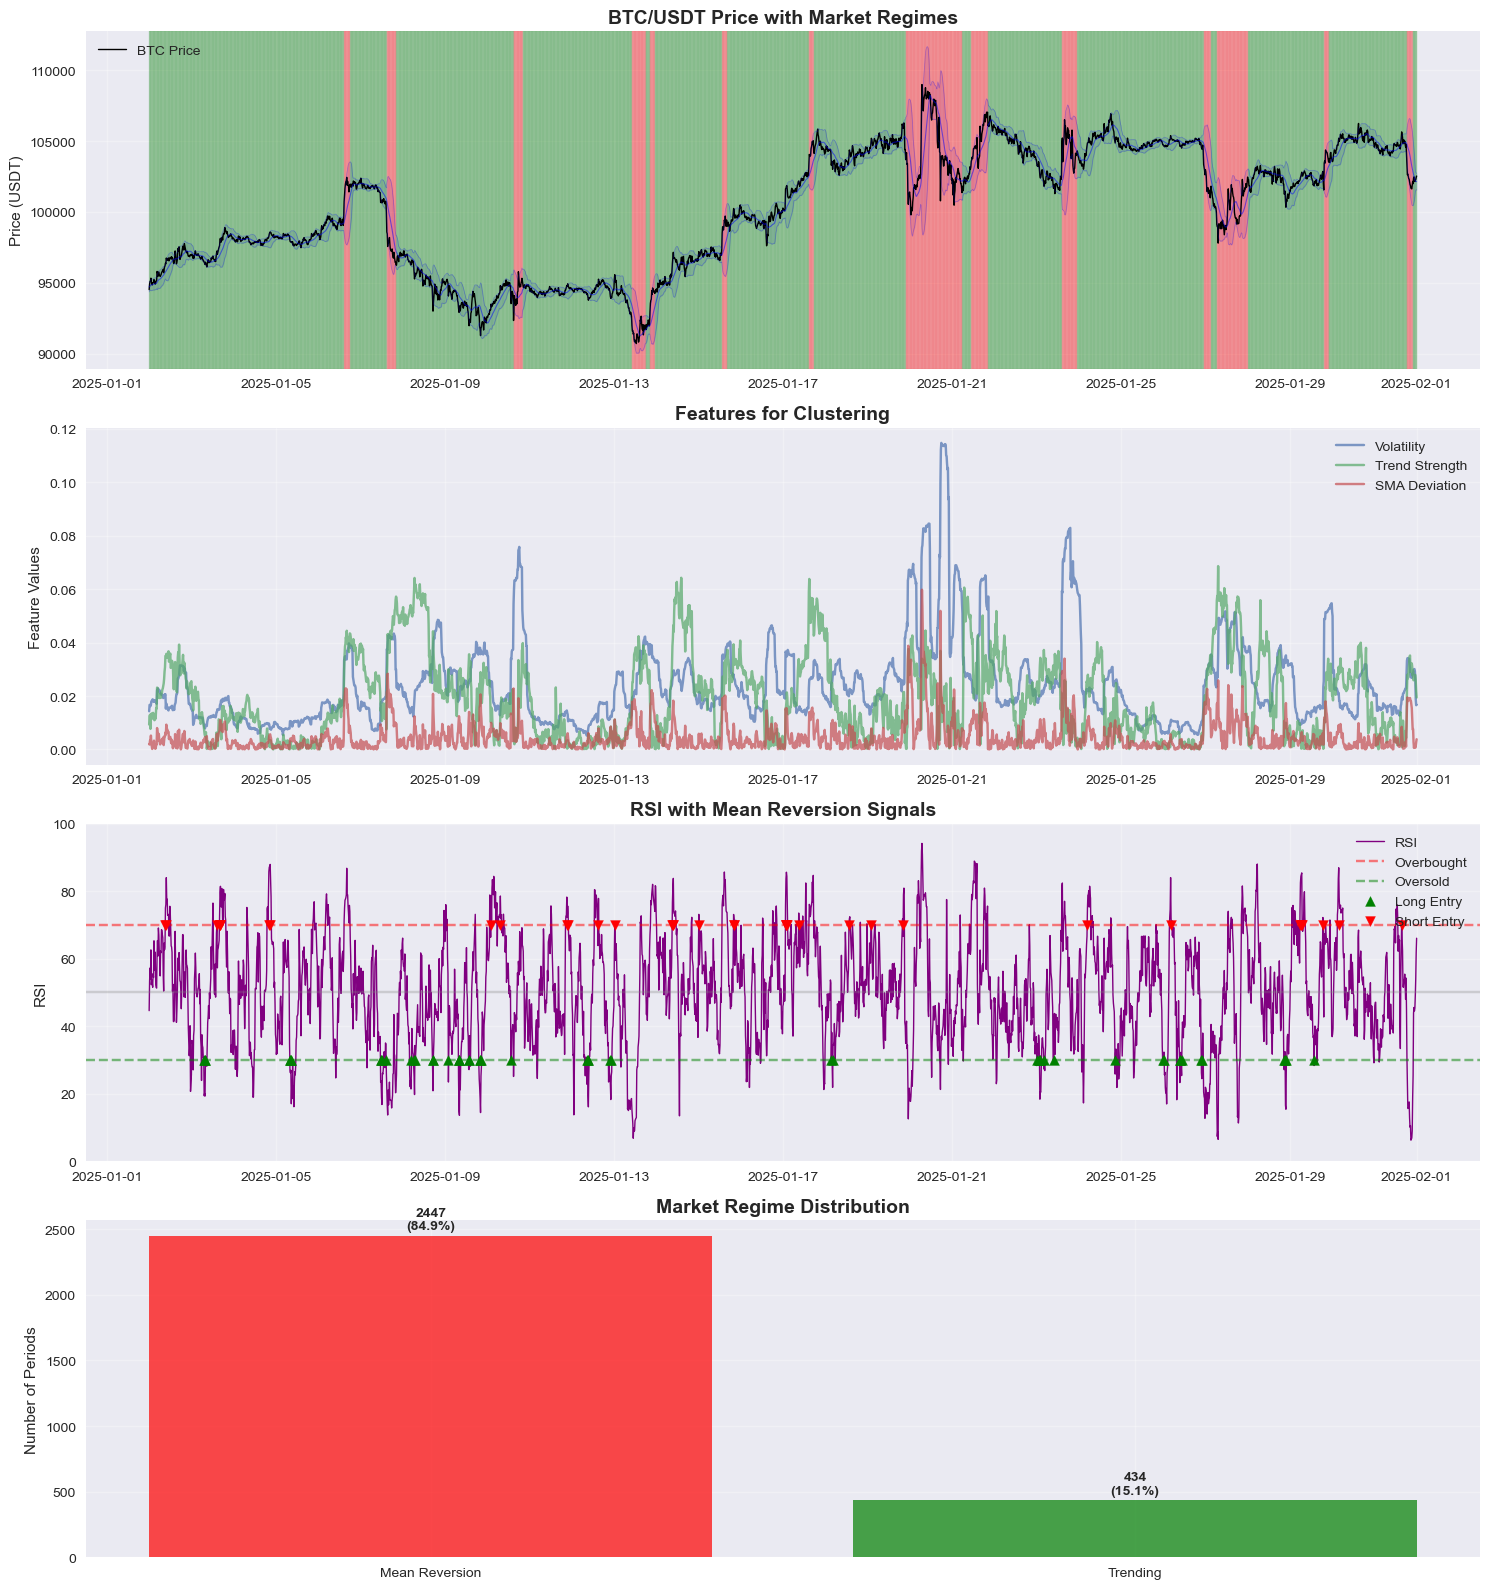

In [6]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# =============== ПАРАМЕТРЫ ===============
SYMBOL = 'BTCUSDT'
INTERVAL = '15m'
START_DATE = '2025-01-01'
END_DATE = '2025-02-01'

# Параметры для анализа стадий рынка
LOOKBACK_PERIOD = 96  # 96 * 15min = 24 часа для расчета индикаторов
VOLATILITY_WINDOW = 20  # Окно для расчета волатильности
RSI_PERIOD = 14  # Период для RSI
BOLLINGER_PERIOD = 20  # Период для полос Боллинджера
BOLLINGER_STD = 2  # Стандартное отклонение для полос Боллинджера

# Параметры K-means
N_CLUSTERS = 2  # 2 кластера: трендовая стадия и mean-reversion
RANDOM_STATE = 42

# Параметры для сигналов
MIN_REGIME_DURATION = 8  # Минимальная длительность режима (8 * 15min = 2 часа)

# =============== ФУНКЦИИ ===============

def get_binance_data(symbol, interval, start_str, end_str):
    """Получение данных с Binance API"""
    url = 'https://api.binance.com/api/v3/klines'
    
    # Конвертация дат в timestamp
    start_ts = int(datetime.strptime(start_str, '%Y-%m-%d').replace(tzinfo=timezone.utc).timestamp() * 1000)
    end_ts = int(datetime.strptime(end_str, '%Y-%m-%d').replace(tzinfo=timezone.utc).timestamp() * 1000)
    
    all_data = []
    current_start = start_ts
    
    while current_start < end_ts:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'endTime': end_ts,
            'limit': 1000
        }
        
        response = requests.get(url, params=params)
        data = response.json()
        
        if not data:
            break
            
        all_data.extend(data)
        current_start = data[-1][6] + 1  # Следующий запрос начинается после последней свечи
        
        if len(data) < 1000:
            break
    
    # Создание DataFrame
    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    # Конвертация типов данных
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    numeric_columns = ['open', 'high', 'low', 'close', 'volume']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col])
    
    df.set_index('timestamp', inplace=True)
    return df[numeric_columns]

def calculate_technical_indicators(df):
    """Расчет технических индикаторов"""
    data = df.copy()
    
    # Простые скользящие средние
    data['sma_20'] = data['close'].rolling(window=20).mean()
    data['sma_50'] = data['close'].rolling(window=50).mean()
    
    # Экспоненциальные скользящие средние
    data['ema_12'] = data['close'].ewm(span=12).mean()
    data['ema_26'] = data['close'].ewm(span=26).mean()
    
    # MACD
    data['macd'] = data['ema_12'] - data['ema_26']
    data['macd_signal'] = data['macd'].ewm(span=9).mean()
    data['macd_histogram'] = data['macd'] - data['macd_signal']
    
    # RSI
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=RSI_PERIOD).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=RSI_PERIOD).mean()
    rs = gain / loss
    data['rsi'] = 100 - (100 / (1 + rs))
    
    # Полосы Боллинджера
    data['bb_middle'] = data['close'].rolling(window=BOLLINGER_PERIOD).mean()
    bb_std = data['close'].rolling(window=BOLLINGER_PERIOD).std()
    data['bb_upper'] = data['bb_middle'] + (bb_std * BOLLINGER_STD)
    data['bb_lower'] = data['bb_middle'] - (bb_std * BOLLINGER_STD)
    data['bb_position'] = (data['close'] - data['bb_lower']) / (data['bb_upper'] - data['bb_lower'])
    
    # Волатильность
    data['returns'] = data['close'].pct_change()
    data['volatility'] = data['returns'].rolling(window=VOLATILITY_WINDOW).std() * np.sqrt(96)  # Годовая волатильность
    
    # Средний истинный диапазон (ATR)
    data['high_low'] = data['high'] - data['low']
    data['high_close'] = abs(data['high'] - data['close'].shift())
    data['low_close'] = abs(data['low'] - data['close'].shift())
    data['true_range'] = data[['high_low', 'high_close', 'low_close']].max(axis=1)
    data['atr'] = data['true_range'].rolling(window=14).mean()
    
    # Тренд (направление цены)
    data['price_change'] = data['close'].pct_change(periods=LOOKBACK_PERIOD)
    data['trend_strength'] = abs(data['price_change'])
    
    # Отклонение от скользящей средней
    data['sma_deviation'] = (data['close'] - data['sma_20']) / data['sma_20']
    
    return data

def create_features_for_clustering(df):
    """Создание признаков для кластеризации"""
    features = pd.DataFrame(index=df.index)
    
    # Волатильность (нормализованная)
    features['volatility'] = df['volatility']
    
    # Сила тренда
    features['trend_strength'] = df['trend_strength']
    
    # Отклонение от скользящей средней
    features['sma_deviation'] = abs(df['sma_deviation'])
    
    # RSI (отклонение от 50)
    features['rsi_deviation'] = abs(df['rsi'] - 50) / 50
    
    # Позиция в полосах Боллинджера
    features['bb_position_extreme'] = np.where(
        df['bb_position'] > 0.8, df['bb_position'] - 0.8,
        np.where(df['bb_position'] < 0.2, 0.2 - df['bb_position'], 0)
    )
    
    # MACD сигнал
    features['macd_strength'] = abs(df['macd_histogram']) / df['close']
    
    # ATR нормализованный
    features['atr_normalized'] = df['atr'] / df['close']
    
    # Удаление NaN значений
    features = features.dropna()
    
    return features

def apply_kmeans_clustering(features):
    """Применение K-means кластеризации"""
    # Стандартизация признаков
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # K-means кластеризация
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=10)
    clusters = kmeans.fit_predict(features_scaled)
    
    # Определение какой кластер соответствует какому режиму
    # Обычно кластер с высокой волатильностью и силой тренда = трендовый режим
    cluster_stats = pd.DataFrame({
        'cluster': clusters,
        'volatility': features['volatility'].values,
        'trend_strength': features['trend_strength'].values
    })
    
    cluster_means = cluster_stats.groupby('cluster').mean()
    
    # Кластер с большей волатильностью и силой тренда = трендовый режим (0)
    # Кластер с меньшей волатильностью = mean reversion режим (1)
    if cluster_means.loc[0, 'volatility'] > cluster_means.loc[1, 'volatility']:
        trending_cluster = 0
        mean_reversion_cluster = 1
    else:
        trending_cluster = 1
        mean_reversion_cluster = 0
    
    # Преобразование меток кластеров
    regime_labels = np.where(clusters == trending_cluster, 'Trending', 'Mean Reversion')
    
    return clusters, regime_labels, kmeans, scaler, trending_cluster, mean_reversion_cluster

def smooth_regime_signals(regime_labels, min_duration=MIN_REGIME_DURATION):
    """Сглаживание сигналов режима для избежания частых переключений"""
    smoothed = regime_labels.copy()
    
    i = 0
    while i < len(smoothed) - min_duration:
        current_regime = smoothed[i]
        
        # Поиск конца текущего режима
        end_idx = i
        while end_idx < len(smoothed) and smoothed[end_idx] == current_regime:
            end_idx += 1
        
        # Если режим короче минимальной длительности, заменяем на предыдущий
        if (end_idx - i) < min_duration and i > 0:
            smoothed[i:end_idx] = smoothed[i-1]
        
        i = end_idx
    
    return smoothed

def generate_trading_signals(df, regime_labels):
    """Генерация торговых сигналов для mean reversion стратегии"""
    signals = pd.DataFrame(index=df.index)
    signals['regime'] = regime_labels
    signals['price'] = df['close']
    
    # Сигналы только в режиме mean reversion
    mean_reversion_mask = (regime_labels == 'Mean Reversion')
    
    # Условия для входа в long позицию (цена ниже нижней полосы Боллинджера + RSI < 30)
    long_condition = (
        mean_reversion_mask &
        (df['close'] < df['bb_lower']) &
        (df['rsi'] < 30)
    )
    
    # Условия для входа в short позицию (цена выше верхней полосы Боллинджера + RSI > 70)
    short_condition = (
        mean_reversion_mask &
        (df['close'] > df['bb_upper']) &
        (df['rsi'] > 70)
    )
    
    # Условия для выхода (возврат к средней линии Боллинджера или RSI к 50)
    exit_condition = (
        (abs(df['close'] - df['bb_middle']) / df['bb_middle'] < 0.005) |
        (abs(df['rsi'] - 50) < 5)
    )
    
    signals['long_entry'] = long_condition
    signals['short_entry'] = short_condition
    signals['exit'] = exit_condition
    signals['strategy_active'] = mean_reversion_mask
    
    return signals

def plot_analysis(df, features, regime_labels, signals):
    """Визуализация анализа"""
    fig, axes = plt.subplots(4, 1, figsize=(15, 16))
    
    # График 1: Цена с режимами
    ax1 = axes[0]
    
    # Раскраска фона по режимам
    trending_mask = regime_labels == 'Trending'
    mean_reversion_mask = regime_labels == 'Mean Reversion'
    
    ax1.plot(df.index, df['close'], color='black', linewidth=1, label='BTC Price')
    ax1.plot(df.index, df['bb_upper'], color='blue', alpha=0.3, linewidth=0.5)
    ax1.plot(df.index, df['bb_middle'], color='blue', alpha=0.5, linewidth=0.8)
    ax1.plot(df.index, df['bb_lower'], color='blue', alpha=0.3, linewidth=0.5)
    ax1.fill_between(df.index, df['bb_lower'], df['bb_upper'], alpha=0.1, color='blue')
    
    # Закрашивание фона по режимам
    for i in range(len(df)):
        if regime_labels[i] == 'Trending':
            ax1.axvspan(df.index[i], df.index[min(i+1, len(df)-1)], alpha=0.2, color='red')
        else:
            ax1.axvspan(df.index[i], df.index[min(i+1, len(df)-1)], alpha=0.2, color='green')
    
    ax1.set_title('BTC/USDT Price with Market Regimes', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price (USDT)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График 2: Признаки для кластеризации
    ax2 = axes[1]
    ax2.plot(features.index, features['volatility'], label='Volatility', alpha=0.7)
    ax2.plot(features.index, features['trend_strength'], label='Trend Strength', alpha=0.7)
    ax2.plot(features.index, features['sma_deviation'], label='SMA Deviation', alpha=0.7)
    ax2.set_title('Features for Clustering', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Feature Values')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # График 3: RSI с сигналами
    ax3 = axes[2]
    ax3.plot(df.index, df['rsi'], color='purple', linewidth=1, label='RSI')
    ax3.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought')
    ax3.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold')
    ax3.axhline(y=50, color='gray', linestyle='-', alpha=0.3)
    
    # Сигналы входа
    long_signals = signals[signals['long_entry']]['price']
    short_signals = signals[signals['short_entry']]['price']
    
    if not long_signals.empty:
        ax3.scatter(long_signals.index, [30]*len(long_signals), color='green', marker='^', s=50, label='Long Entry', zorder=5)
    if not short_signals.empty:
        ax3.scatter(short_signals.index, [70]*len(short_signals), color='red', marker='v', s=50, label='Short Entry', zorder=5)
    
    ax3.set_title('RSI with Mean Reversion Signals', fontsize=14, fontweight='bold')
    ax3.set_ylabel('RSI')
    ax3.set_ylim(0, 100)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # График 4: Распределение режимов
    ax4 = axes[3]
    regime_counts = pd.Series(regime_labels).value_counts()
    colors = ['red', 'green']
    bars = ax4.bar(regime_counts.index, regime_counts.values, color=colors, alpha=0.7)
    ax4.set_title('Market Regime Distribution', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Number of Periods')
    
    # Добавление процентов на столбцы
    total = len(regime_labels)
    for bar, count in zip(bars, regime_counts.values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + total*0.01,
                f'{count}\n({count/total*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')
    
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def print_analysis_summary(df, regime_labels, signals):
    """Печать сводки анализа"""
    print("="*60)
    print("АНАЛИЗ СТАДИЙ РЫНКА BTC/USDT")
    print("="*60)
    
    # Основная статистика
    total_periods = len(regime_labels)
    trending_periods = sum(regime_labels == 'Trending')
    mean_reversion_periods = sum(regime_labels == 'Mean Reversion')
    
    print(f"Период анализа: {df.index[0].strftime('%Y-%m-%d %H:%M')} - {df.index[-1].strftime('%Y-%m-%d %H:%M')}")
    print(f"Общее количество периодов: {total_periods}")
    print(f"Трендовых периодов: {trending_periods} ({trending_periods/total_periods*100:.1f}%)")
    print(f"Mean Reversion периодов: {mean_reversion_periods} ({mean_reversion_periods/total_periods*100:.1f}%)")
    print()
    
    # Статистика сигналов
    long_signals = signals['long_entry'].sum()
    short_signals = signals['short_entry'].sum()
    total_signals = long_signals + short_signals
    
    print("СТАТИСТИКА СИГНАЛОВ MEAN REVERSION:")
    print(f"Всего сигналов: {total_signals}")
    print(f"Long сигналов: {long_signals}")
    print(f"Short сигналов: {short_signals}")
    print()
    
    # Рекомендации
    print("РЕКОМЕНДАЦИИ:")
    mr_percentage = mean_reversion_periods / total_periods * 100
    if mr_percentage > 60:
        print("✅ Высокий процент Mean Reversion периодов - стратегия может быть эффективной")
    elif mr_percentage > 40:
        print("⚠️  Умеренный процент Mean Reversion периодов - требуется осторожность")
    else:
        print("❌ Низкий процент Mean Reversion периодов - стратегия может быть неэффективной")
    
    if total_signals > 0:
        avg_signals_per_day = total_signals / (total_periods * 15 / (24 * 60))
        print(f"📊 Среднее количество сигналов в день: {avg_signals_per_day:.1f}")
    
    print("="*60)

# =============== ОСНОВНОЙ КОД ===============

def main():
    print("Загрузка данных с Binance...")
    
    # Загрузка данных
    df = get_binance_data(SYMBOL, INTERVAL, START_DATE, END_DATE)
    print(f"Загружено {len(df)} свечей")
    
    # Расчет технических индикаторов
    print("Расчет технических индикаторов...")
    df = calculate_technical_indicators(df)
    
    # Создание признаков для кластеризации
    print("Создание признаков для кластеризации...")
    features = create_features_for_clustering(df)
    
    # Применение K-means
    print("Применение K-means кластеризации...")
    clusters, regime_labels, kmeans, scaler, trending_cluster, mean_reversion_cluster = apply_kmeans_clustering(features)
    
    # Сглаживание сигналов
    print("Сглаживание сигналов режима...")
    regime_labels_smoothed = smooth_regime_signals(regime_labels)
    
    # Обновление DataFrame с результатами кластеризации
    df_analysis = df.loc[features.index].copy()
    df_analysis['regime'] = regime_labels_smoothed
    
    # Генерация торговых сигналов
    print("Генерация торговых сигналов...")
    signals = generate_trading_signals(df_analysis, regime_labels_smoothed)
    
    # Печать сводки
    print_analysis_summary(df_analysis, regime_labels_smoothed, signals)
    
    # Визуализация
    print("Создание графиков...")
    plot_analysis(df_analysis, features, regime_labels_smoothed, signals)
    
    return df_analysis, features, regime_labels_smoothed, signals, kmeans, scaler

if __name__ == "__main__":
    df_result, features_result, regimes_result, signals_result, model, scaler_result = main()